In [ ]:
#!pip install nltk
#!conda install -c anaconda nltk

In [61]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import string
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import re
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string
from string import digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from nltk.tokenize import RegexpTokenizer, regexp_tokenize, word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [2]:
df = pd.read_csv('Data/Phase4_tweet_dataset.csv', encoding= 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [ ]:
df.info()

In [3]:
df.dropna(inplace = True)

In [ ]:
df.info()

In [4]:
## Checking unique values
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Positive emotion                      2672
Negative emotion                       519
No emotion toward brand or product      91
I can't tell                             9
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
df = df.drop(df[(df.is_there_an_emotion_directed_at_a_brand_or_product != "Positive emotion") & (df.is_there_an_emotion_directed_at_a_brand_or_product != "Negative emotion")].index)

In [34]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

Positive emotion    2672
Negative emotion     519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [35]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley g hr tweet rise dead need upgrade plugi...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome app likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer tim re...
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,pr guy convince switch back great coverage pri...
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,papyrus sort like nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say tv might run playstation xbox essen...
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,always use camera b c image stabilizer mode su...


In [9]:
sw = stopwords.words('english')
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
sw.extend(["i'd", "i'm", "w", "@mention", "#sxswrt", "#ipad", "#apple", "u", "#sxsw", "sxsw", "mention", "ipad", "apple", "iphone", "link", "rt", "google", "quot", "linkrt", "amp", "austin"])

In [11]:
##Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
### need to remove numeric values 
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    
#     tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
#     doc = tweet_tokenizer.tokenize(doc)
    
    doc = [word for word in doc if word not in sw] #getting rid of stopwords
    doc = [word for word in doc if string.punctuation.find(word) == -1] #getting rid of punctuation
    
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]

    lemmatizer = WordNetLemmatizer() #lemmatizing
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc] 
    doc = [re.sub(r"\d+", "", word) for word in doc] #getting rid of numeric values

    return ' '.join(doc)

In [13]:
#adding '...' to punctuation string
string.punctuation += '...'
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~...'

In [14]:
df['clean_tweets'] = df['tweet_text'].apply(doc_preparer)

In [15]:
#body of text
corpus = ''
for i in df['clean_tweets'][:]:
    corpus += i

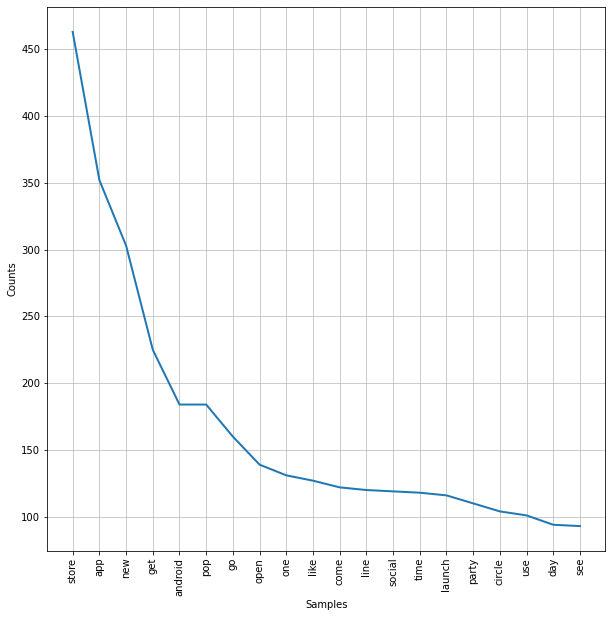

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [16]:
fdist = FreqDist(doc_preparer(corpus, stop_words=sw).split())
plt.figure(figsize=(10, 10))
fdist.plot(20)

In [17]:
X = df.drop(columns=['is_there_an_emotion_directed_at_a_brand_or_product', 'tweet_text'], axis =1)
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [19]:
cv = CountVectorizer(input='content') #ngram_range=(3, 500)

In [20]:
X_train_vec = cv.fit_transform(X_train['clean_tweets'])
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [21]:
X_test_vec = cv.transform(X_test['clean_tweets'])
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)


In [64]:
#Dummy classifier
dc = DummyClassifier(strategy='stratified')
dc.fit(X_train_vec, y_train)

print(cross_val_score(dc, X_train_vec, y_train).mean())

0.7208549890374821


In [65]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

print(cross_val_score(mnb, X_train_vec, y_train).mean())

0.844127846542221


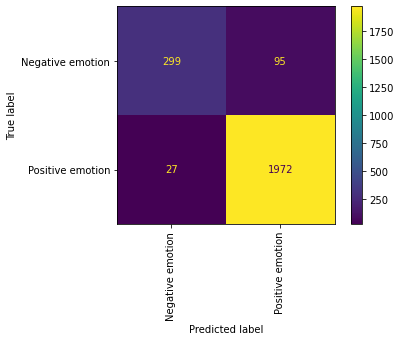

In [66]:
plot_confusion_matrix(mnb, X_train_vec, y_train, xticks_rotation='vertical');

In [103]:
#overfitted model - might change penalty to l1
sgd = SGDClassifier(penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None, n_iter_no_change=20)
sgd.fit(X_train_vec, y_train)
sgd_pred = sgd.predict(X_train_vec)

print("Cross validation", cross_val_score(sgd, X_train_vec, y_train).mean())
print("Recall", recall_score(y_train, sgd_pred, average='weighted'))
print("Accuracy", accuracy_score(y_train, sgd_pred))

Cross validation 0.872545662599034
Recall 0.9740910990388634
Accuracy 0.9740910990388634


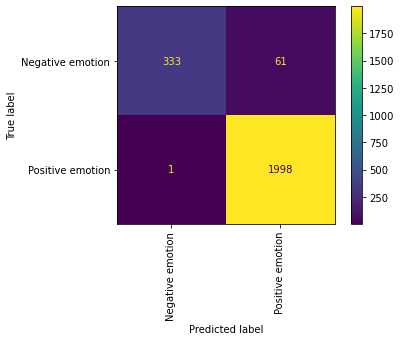

In [80]:
#overfitted
plot_confusion_matrix(sgd, X_train_vec, y_train, xticks_rotation='vertical');

In [ ]:
# pip install wordcloud

In [81]:
positive_tweets = df[df['is_there_an_emotion_directed_at_a_brand_or_product']  == 'Positive emotion']['clean_tweets']

In [82]:
#body of text
corpus_pos = ''
for i in positive_tweets:
    corpus_pos += i

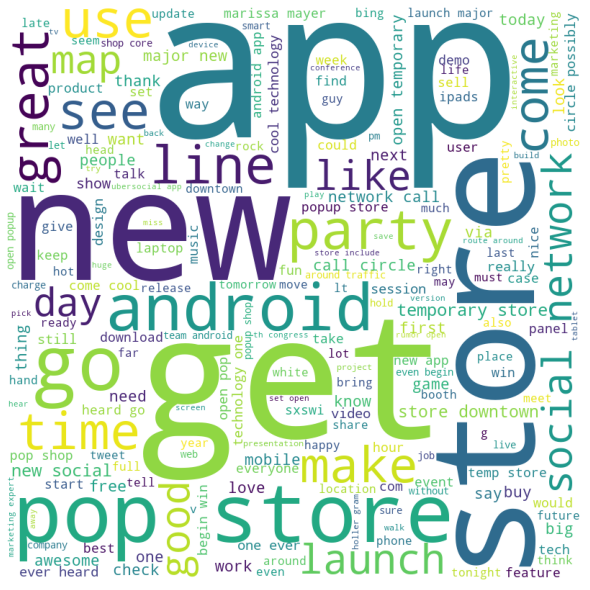

In [83]:
# Python program to generate WordCloud
 
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = sw,
                min_font_size = 10).generate(corpus_pos)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [84]:
X_train_ind = X_train_vec.reset_index(drop=True)
y_train_ind = y_train.reset_index(drop= True)

In [85]:
X_train_vec.shape

(2393, 3921)

In [86]:
y_train_inds = y_train_ind.to_numpy()
y_train_inds

array(['Positive emotion', 'Positive emotion', 'Positive emotion', ...,
       'Positive emotion', 'Negative emotion', 'Positive emotion'],
      dtype=object)

In [87]:
X_train_inds = X_train_ind.to_numpy()

In [88]:
smote = SMOTE(random_state = 11, sampling_strategy='auto')
X_train_sm, y_train_sm = smote.fit_resample(X = X_train_inds, y = y_train_inds)

In [89]:
X_train_sm.shape

(3998, 3921)

In [90]:
y_train_sm.shape

(3998,)

In [91]:
sgd1 = SGDClassifier(penalty='l2', alpha=1e-3, random_state=42, max_iter=10, tol=None)
sgd1.fit(X_train_sm, y_train_sm)
sgd_pred1 = sgd1.predict(X_test_vec)
print("Recall", recall_score(y_test, sgd_pred1, average='weighted'))
print("Accuracy", accuracy_score(y_test, sgd_pred1))

Recall 0.8170426065162907
Accuracy 0.8170426065162907
